In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'zh'
target_lang = 'fr'
model_size = '7b'
prefix = "./data/langs/"
type = 'tuned-chinese-en'


In [4]:
# Parameters
model_size = "13b"
target_lang = "en"
input_lang = "ru"
type = "tuned-chinese"


In [5]:
df_en_input = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_target = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()

In [6]:

llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
latent="en"
if type == 'logit':
    llama_lens = LogitLens.from_model(llama).to("cuda")
    out_dir = f'./visuals/logit'
    
if type == 'tuned':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-{model_size}-hf").to("cuda")
    out_dir = f'./visuals/tuned'
if type == 'tuned-chinese':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"../tuned-lens/my_lenses/chinese/{model_size}").to("cuda")
    out_dir = f'./visuals/tuned-chinese'
    latent = 'zh'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
if type == 'tuned-chinese-en':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"../tuned-lens/my_lenses/chinese/{model_size}").to("cuda")
    out_dir = f'./visuals/tuned-chinese-en'
    latent = 'en'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=5120, out_features=32000, bias=False)
)
U torch.Size([32000, 5120]) weights torch.Size([1, 5120])


0.11461826413869858


In [8]:
count = 0
for idx, word in enumerate(df_en_target['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_target)} are single tokens')

if input_lang == target_lang:
    df_en_target_input = df_en_target.copy()
    if latent == 'zh':
      df_en_target_input = df_en_target.copy()
      chinese = chinese.loc[chinese["word_original"].isin(df_en_input["word_original"])]
      df_en_target_input= df_en_target_input.loc[df_en_target_input["word_original"].isin(chinese["word_original"])]
      chinese.sort_values(by="word_original", inplace=True)
      df_en_target_input.sort_values(by="word_original", inplace=True)
      chinese.reset_index(drop=True, inplace=True)
      df_en_target_input.reset_index(drop=True, inplace=True)
      df_en_target_input["word_original"] = chinese["word_translation"]
    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation': target_lang if target_lang != latent else f'{latent}_tgt'}, 
                                inplace=True)
    
else:
    df_en_target_input = df_en_target.merge(df_en_input, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    if latent == 'zh':
      chinese = chinese.loc[chinese["word_original"].isin(df_en_target_input["word_original"])]
      df_en_target_input= df_en_target_input.loc[df_en_target_input["word_original"].isin(chinese["word_original"])]
      chinese.sort_values(by="word_original", inplace=True)
      df_en_target_input.sort_values(by="word_original", inplace=True)
      chinese.reset_index(drop=True, inplace=True)
      df_en_target_input.reset_index(drop=True, inplace=True)
      df_en_target_input["word_original"] = chinese["word_translation"]

    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation_{target_lang}': target_lang if target_lang != latent else f'{latent}_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != latent else f'{latent}_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != latent:
    for i, row in df_en_target_input.iterrows():
        if row[latent].lower() in row[target_lang].lower():
            df_en_target_input.drop(i, inplace=True)

print(f'final length of df_{latent}_{target_lang}_{input_lang}: {len(df_en_target_input)}')

for en 132 of 132 are single tokens
final length of df_zh_en_ru: 114


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent=latent):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, latent)
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != latent and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
dataset = []
for ind in tqdm(range(len(df_en_target_input))):
    d = next(sample(df_en_target_input, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                               | 0/114 [00:00<?, ?it/s]

  1%|█▋                                                                                                                                                                                                     | 1/114 [00:00<00:21,  5.30it/s]

  2%|███▍                                                                                                                                                                                                   | 2/114 [00:00<00:16,  6.81it/s]

  3%|█████▏                                                                                                                                                                                                 | 3/114 [00:00<00:15,  7.03it/s]

  4%|██████▉                                                                                                                                                                                                | 4/114 [00:00<00:16,  6.76it/s]

  4%|████████▋                                                                                                                                                                                              | 5/114 [00:00<00:15,  7.05it/s]

  5%|██████████▍                                                                                                                                                                                            | 6/114 [00:00<00:16,  6.72it/s]

  6%|████████████▏                                                                                                                                                                                          | 7/114 [00:01<00:15,  7.06it/s]

  7%|█████████████▉                                                                                                                                                                                         | 8/114 [00:01<00:15,  6.87it/s]

  8%|███████████████▋                                                                                                                                                                                       | 9/114 [00:01<00:15,  6.97it/s]

  9%|█████████████████▎                                                                                                                                                                                    | 10/114 [00:01<00:15,  6.80it/s]

 10%|███████████████████                                                                                                                                                                                   | 11/114 [00:01<00:15,  6.66it/s]

 11%|████████████████████▊                                                                                                                                                                                 | 12/114 [00:01<00:15,  6.75it/s]

 11%|██████████████████████▌                                                                                                                                                                               | 13/114 [00:01<00:15,  6.58it/s]

 12%|████████████████████████▎                                                                                                                                                                             | 14/114 [00:02<00:15,  6.39it/s]

 13%|██████████████████████████                                                                                                                                                                            | 15/114 [00:02<00:14,  6.81it/s]

 14%|███████████████████████████▊                                                                                                                                                                          | 16/114 [00:02<00:13,  7.17it/s]

 15%|█████████████████████████████▌                                                                                                                                                                        | 17/114 [00:02<00:13,  7.25it/s]

 16%|███████████████████████████████▎                                                                                                                                                                      | 18/114 [00:02<00:14,  6.80it/s]

 17%|█████████████████████████████████                                                                                                                                                                     | 19/114 [00:02<00:14,  6.35it/s]

 18%|██████████████████████████████████▋                                                                                                                                                                   | 20/114 [00:02<00:14,  6.63it/s]

 18%|████████████████████████████████████▍                                                                                                                                                                 | 21/114 [00:03<00:13,  6.75it/s]

 19%|██████████████████████████████████████▏                                                                                                                                                               | 22/114 [00:03<00:13,  6.92it/s]

 20%|███████████████████████████████████████▉                                                                                                                                                              | 23/114 [00:03<00:12,  7.25it/s]

 21%|█████████████████████████████████████████▋                                                                                                                                                            | 24/114 [00:03<00:13,  6.92it/s]

 22%|███████████████████████████████████████████▍                                                                                                                                                          | 25/114 [00:03<00:12,  7.06it/s]

 23%|█████████████████████████████████████████████▏                                                                                                                                                        | 26/114 [00:03<00:13,  6.71it/s]

 24%|██████████████████████████████████████████████▉                                                                                                                                                       | 27/114 [00:03<00:12,  7.00it/s]

 25%|████████████████████████████████████████████████▋                                                                                                                                                     | 28/114 [00:04<00:12,  6.76it/s]

 25%|██████████████████████████████████████████████████▎                                                                                                                                                   | 29/114 [00:04<00:12,  7.03it/s]

 26%|████████████████████████████████████████████████████                                                                                                                                                  | 30/114 [00:04<00:14,  5.99it/s]

 27%|█████████████████████████████████████████████████████▊                                                                                                                                                | 31/114 [00:04<00:12,  6.50it/s]

 28%|███████████████████████████████████████████████████████▌                                                                                                                                              | 32/114 [00:04<00:11,  6.92it/s]

 29%|█████████████████████████████████████████████████████████▎                                                                                                                                            | 33/114 [00:04<00:12,  6.64it/s]

 30%|███████████████████████████████████████████████████████████                                                                                                                                           | 34/114 [00:05<00:11,  6.67it/s]

 31%|████████████████████████████████████████████████████████████▊                                                                                                                                         | 35/114 [00:05<00:11,  6.88it/s]

 32%|██████████████████████████████████████████████████████████████▌                                                                                                                                       | 36/114 [00:05<00:10,  7.22it/s]

 32%|████████████████████████████████████████████████████████████████▎                                                                                                                                     | 37/114 [00:05<00:10,  7.14it/s]

 33%|██████████████████████████████████████████████████████████████████                                                                                                                                    | 38/114 [00:05<00:11,  6.41it/s]

 34%|███████████████████████████████████████████████████████████████████▋                                                                                                                                  | 39/114 [00:05<00:11,  6.50it/s]

 35%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                | 40/114 [00:05<00:11,  6.57it/s]

 36%|███████████████████████████████████████████████████████████████████████▏                                                                                                                              | 41/114 [00:06<00:11,  6.40it/s]

 37%|████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 42/114 [00:06<00:10,  6.75it/s]

 38%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 43/114 [00:06<00:10,  6.76it/s]

 39%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 44/114 [00:06<00:10,  6.95it/s]

 39%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 45/114 [00:06<00:09,  7.18it/s]

 40%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 46/114 [00:06<00:10,  6.33it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 47/114 [00:06<00:09,  6.96it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 48/114 [00:07<00:09,  7.09it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 49/114 [00:07<00:09,  6.54it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 50/114 [00:07<00:10,  6.36it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 51/114 [00:07<00:09,  6.31it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 52/114 [00:07<00:09,  6.85it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 53/114 [00:07<00:09,  6.65it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 54/114 [00:08<00:09,  6.22it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 55/114 [00:08<00:09,  6.45it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 56/114 [00:08<00:08,  7.08it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 57/114 [00:08<00:07,  7.38it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 58/114 [00:08<00:07,  7.27it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 59/114 [00:08<00:07,  7.11it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 60/114 [00:08<00:08,  6.38it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 61/114 [00:09<00:08,  6.05it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 62/114 [00:09<00:07,  6.56it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 63/114 [00:09<00:07,  6.78it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 64/114 [00:09<00:07,  6.43it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 65/114 [00:09<00:08,  6.01it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 66/114 [00:09<00:07,  6.29it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 67/114 [00:09<00:07,  6.68it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 68/114 [00:10<00:07,  6.15it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 69/114 [00:10<00:07,  6.34it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 70/114 [00:10<00:07,  5.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 71/114 [00:10<00:06,  6.59it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 72/114 [00:10<00:06,  6.47it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 73/114 [00:10<00:06,  6.66it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 74/114 [00:11<00:06,  6.61it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 75/114 [00:11<00:05,  6.92it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 76/114 [00:11<00:05,  6.69it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 77/114 [00:11<00:05,  7.38it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 78/114 [00:11<00:04,  7.60it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 79/114 [00:11<00:04,  7.57it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 80/114 [00:11<00:04,  7.59it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 81/114 [00:11<00:04,  7.97it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 82/114 [00:12<00:03,  8.14it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 83/114 [00:12<00:03,  8.28it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 84/114 [00:12<00:03,  7.98it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 85/114 [00:12<00:03,  7.64it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 86/114 [00:12<00:03,  7.24it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 87/114 [00:12<00:03,  7.16it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 88/114 [00:12<00:03,  6.94it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 89/114 [00:13<00:03,  6.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 90/114 [00:13<00:03,  6.68it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 91/114 [00:13<00:03,  6.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 92/114 [00:13<00:03,  6.78it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 93/114 [00:13<00:03,  6.43it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 94/114 [00:13<00:03,  6.45it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 95/114 [00:14<00:03,  5.69it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 96/114 [00:14<00:03,  5.83it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 97/114 [00:14<00:02,  6.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 98/114 [00:14<00:02,  6.95it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 99/114 [00:14<00:02,  6.71it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 100/114 [00:14<00:01,  7.39it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 101/114 [00:14<00:01,  7.81it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 102/114 [00:15<00:01,  6.97it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 103/114 [00:15<00:01,  6.90it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 104/114 [00:15<00:01,  7.57it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 105/114 [00:15<00:01,  7.64it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 106/114 [00:15<00:01,  7.36it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 107/114 [00:15<00:00,  7.80it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 108/114 [00:15<00:00,  7.16it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 109/114 [00:16<00:00,  6.49it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 110/114 [00:16<00:00,  6.10it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 111/114 [00:16<00:00,  6.06it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 112/114 [00:16<00:00,  6.33it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 113/114 [00:16<00:00,  6.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:16<00:00,  6.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:16<00:00,  6.79it/s]

In [12]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [13]:
df["prompt"][0]

'Русский: "снег" - English: "snow"\nРусский: "мост" - English: "bridge"\nРусский: "предмет" - English: "item"\nРусский: "красный" - English: "red"\nРусский: "попытка" - English: "'

In [14]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    tensors=[]
    hd= []
    for i in range(len(model.model.layers)):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
        hd+=[lens.transform_hidden(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hd)
    return tensors,hidden_states
        

In [15]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:01,  1.32s/it]

2it [00:01,  1.48it/s]

3it [00:01,  2.14it/s]

4it [00:01,  2.69it/s]

5it [00:02,  3.01it/s]

6it [00:02,  3.36it/s]

7it [00:02,  3.64it/s]

8it [00:02,  3.72it/s]

9it [00:03,  3.93it/s]

10it [00:03,  4.08it/s]

11it [00:03,  4.20it/s]

12it [00:03,  4.30it/s]

13it [00:04,  4.36it/s]

14it [00:04,  4.41it/s]

15it [00:04,  4.17it/s]

16it [00:04,  4.26it/s]

17it [00:05,  4.31it/s]

18it [00:05,  4.36it/s]

19it [00:05,  4.39it/s]

20it [00:05,  4.49it/s]

21it [00:05,  4.45it/s]

22it [00:06,  4.36it/s]

23it [00:06,  4.20it/s]

24it [00:06,  3.64it/s]

25it [00:07,  3.52it/s]

26it [00:07,  3.62it/s]

27it [00:07,  3.68it/s]

28it [00:07,  3.79it/s]

29it [00:08,  3.97it/s]

30it [00:08,  3.95it/s]

31it [00:08,  4.12it/s]

32it [00:08,  4.26it/s]

33it [00:08,  4.36it/s]

34it [00:09,  4.32it/s]

35it [00:09,  4.30it/s]

36it [00:09,  4.34it/s]

37it [00:09,  4.28it/s]

38it [00:10,  4.31it/s]

39it [00:10,  4.30it/s]

40it [00:10,  4.28it/s]

41it [00:10,  4.35it/s]

42it [00:11,  4.31it/s]

43it [00:11,  4.30it/s]

44it [00:11,  4.32it/s]

45it [00:11,  4.27it/s]

46it [00:11,  4.33it/s]

47it [00:12,  4.34it/s]

48it [00:12,  4.34it/s]

49it [00:12,  4.39it/s]

50it [00:12,  4.33it/s]

51it [00:13,  4.33it/s]

52it [00:13,  4.37it/s]

53it [00:13,  4.37it/s]

54it [00:13,  4.39it/s]

55it [00:14,  4.34it/s]

56it [00:14,  4.35it/s]

57it [00:14,  4.28it/s]

58it [00:14,  4.33it/s]

59it [00:14,  4.32it/s]

60it [00:15,  4.35it/s]

61it [00:15,  4.35it/s]

62it [00:15,  4.38it/s]

63it [00:15,  4.37it/s]

64it [00:16,  4.36it/s]

65it [00:16,  4.33it/s]

66it [00:16,  4.33it/s]

67it [00:16,  4.32it/s]

68it [00:17,  4.32it/s]

69it [00:17,  4.32it/s]

70it [00:17,  4.28it/s]

71it [00:17,  4.29it/s]

72it [00:17,  4.26it/s]

73it [00:18,  4.26it/s]

74it [00:18,  4.27it/s]

75it [00:18,  4.26it/s]

76it [00:18,  4.26it/s]

77it [00:19,  4.15it/s]

78it [00:19,  4.20it/s]

79it [00:19,  4.25it/s]

80it [00:19,  4.22it/s]

81it [00:20,  4.27it/s]

82it [00:20,  4.34it/s]

83it [00:20,  4.40it/s]

84it [00:20,  4.41it/s]

85it [00:21,  4.37it/s]

86it [00:21,  4.38it/s]

87it [00:21,  4.40it/s]

88it [00:21,  4.30it/s]

89it [00:21,  4.30it/s]

90it [00:22,  4.30it/s]

91it [00:22,  4.21it/s]

92it [00:22,  4.21it/s]

93it [00:22,  4.22it/s]

94it [00:23,  4.23it/s]

95it [00:23,  4.23it/s]

96it [00:23,  4.28it/s]

97it [00:23,  4.32it/s]

98it [00:24,  4.35it/s]

99it [00:24,  4.39it/s]

100it [00:24,  4.43it/s]

101it [00:24,  4.41it/s]

102it [00:24,  4.43it/s]

103it [00:25,  4.49it/s]

104it [00:25,  4.45it/s]

105it [00:25,  4.47it/s]

106it [00:25,  4.51it/s]

107it [00:26,  4.48it/s]

108it [00:26,  4.51it/s]

109it [00:26,  4.55it/s]

110it [00:26,  4.51it/s]

111it [00:26,  4.47it/s]

112it [00:27,  4.30it/s]

113it [00:27,  4.31it/s]

114it [00:27,  4.43it/s]

114it [00:27,  4.13it/s]

/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


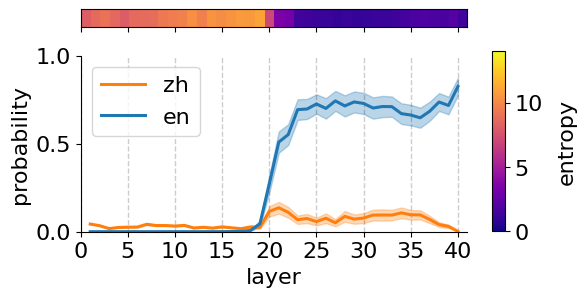

In [16]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.jpg', dpi=300, bbox_inches='tight')

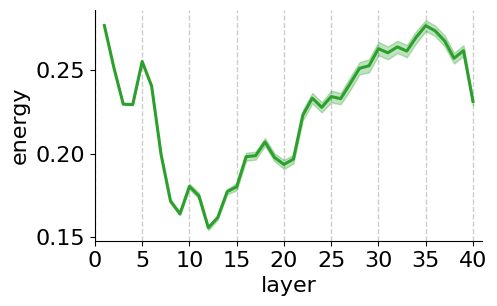

In [17]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.jpg', dpi=300, bbox_inches='tight')